In [6]:
import numpy as np
import heapq  # Priority queue
import logging
import math
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

class Node:
    def __init__(self, idx, data):
        self.idx = idx  # unique identifier
        self.data = data  # feature vector
        self.neighbors = []  # neighboring nodes

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)

    def __str__(self):
        return f"Node(idx={self.idx}, data={self.data.tolist()})"

class NSWGraph:
    def __init__(self, m=3):
        self.graph = []
        self.m = m # maximum number of edges each node has

    def distance(self, node1, node2):
        return math.sqrt(sum((x-y)**2 for x, y in zip(node1.data, node2.data)))

    def insert(self, node):
        logging.info(f"Inserting node {node.idx} with vector {node.data} into the graph...")
        if len(self.graph) > 0:
            candidates = self.graph[:]
            for _ in range(self.m):
                if not candidates:
                    break
                nearest = min(candidates, key=lambda x: self.distance(x, node))
                node.add_neighbor(nearest)
                nearest.add_neighbor(node)
                candidates.remove(nearest)
                logging.info(f"Node {node.idx} connected with node {nearest.idx}")
        self.graph.append(node)
        logging.info(f"Node {node.idx} inserted.\n")

    def search(self, query, k):
        logging.info(f"Searching {k} nearest neighbors for node {query.data}...")
        visited = set()
        candidates = [(0, self.graph[0])]
        nearest_neighbors = []
        while candidates and len(nearest_neighbors) < k:
            _, current_node = heapq.heappop(candidates)
            if current_node in visited:
                continue
            visited.add(current_node)

            d = self.distance(current_node, query)
            logging.info(f"Current candidate {current_node} at distance {d}")

            if len(nearest_neighbors) < k or d < nearest_neighbors[-1][0]:
                heapq.heappush(nearest_neighbors, (d, current_node))
                logging.info(f"Node {current_node.idx} considered as a neighbor with distance {d:.4f}")

            for neighbor in current_node.neighbors:
                if neighbor not in visited:
                    logging.info(f"Node {neighbor} added to list of candidates")
                    heapq.heappush(candidates, (self.distance(neighbor, query), neighbor))

        logging.info(f"Search complete. {k} nearest neighbors found.\n")
        return [x[1] for x in nearest_neighbors[:k]]
    
    def remove_node(self, remove_idx):
        # Log: Removing node
        print(f"Removing node with idx: {remove_idx}")

        # Validate index
        if remove_idx >= len(self.graph) or remove_idx < 0:
            print("Index out of bounds. Node not removed.")
            return

        # Remove references to the node in neighbors' lists
        node_to_remove = self.graph[remove_idx]
        for node in self.graph:
            node.neighbors = [neighbor for neighbor in node.neighbors if neighbor.idx != remove_idx]

        # Remove the node from the graph
        del self.graph[remove_idx]

        # Update indexes of nodes that followed the removed node
        for i in range(remove_idx, len(self.graph)):
            self.graph[i].idx -= 1

        # Log: Node removed
        print(f"Node with idx {remove_idx} removed.")
        
    def ensure_connectivity(self):
        """
        Ensure that the graph is fully connected by connecting
        disconnected components.
        """
        visited = set()
        components = []

        def dfs(node, component):
            """Depth-first search to identify connected components."""
            visited.add(node.idx)
            component.append(node)
            for neighbor in node.neighbors:
                if neighbor.idx not in visited:
                    dfs(neighbor, component)

        # Identify connected components
        for node in self.graph:
            if node.idx not in visited:
                component = []
                dfs(node, component)
                components.append(component)

        # Connect components
        for i in range(1, len(components)):
            # Find the pair of nodes with minimum distance between components
            min_dist = float('inf')
            min_pair = None
            for node1 in components[i-1]:
                for node2 in components[i]:
                    dist = self.distance(node1, node2)
                    if dist < min_dist:
                        min_dist = dist
                        min_pair = (node1, node2)

            # Connect the closest nodes between components
            min_pair[0].neighbors.append(min_pair[1])
            min_pair[1].neighbors.append(min_pair[0])


def visualize_nsw(graph, query=None, k_neighbors=None):
    plt.figure(figsize=(10, 10))

    # Plot all nodes
    for node in graph:
        plt.plot(node.data[0], node.data[1], 'bo')

    # Plot edges
    for node in graph:
        for neighbor in node.neighbors:
            plt.plot([node.data[0], neighbor.data[0]], [node.data[1], neighbor.data[1]], 'b-')

    # Highlight query node if provided
    if query is not None:
        plt.plot(query.data[0], query.data[1], 'go', markersize=10)

    # Highlight and connect k-nearest neighbors if provided
    if k_neighbors is not None:
        for neighbor in k_neighbors:
            plt.plot(neighbor.data[0], neighbor.data[1], 'ro')
            if query is not None:
                plt.plot([query.data[0], neighbor.data[0]], [query.data[1], neighbor.data[1]], 'r--')

    plt.title("Navigable Small-World Graph")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()



INFO:root:Inserting node 0 with vector [0.98901151 0.54954473] into the graph...
INFO:root:Node 0 inserted.

INFO:root:Inserting node 1 with vector [0.2814473  0.07728957] into the graph...
INFO:root:Node 1 connected with node 0
INFO:root:Node 1 inserted.

INFO:root:Inserting node 2 with vector [0.4444695  0.47280797] into the graph...
INFO:root:Node 2 connected with node 1
INFO:root:Node 2 connected with node 0
INFO:root:Node 2 inserted.

INFO:root:Inserting node 3 with vector [0.048522   0.16332445] into the graph...
INFO:root:Node 3 connected with node 1
INFO:root:Node 3 connected with node 2
INFO:root:Node 3 connected with node 0
INFO:root:Node 3 inserted.

INFO:root:Inserting node 4 with vector [0.11595071 0.62739168] into the graph...
INFO:root:Node 4 connected with node 2
INFO:root:Node 4 connected with node 3
INFO:root:Node 4 connected with node 1
INFO:root:Node 4 inserted.

INFO:root:Inserting node 5 with vector [0.85618205 0.65010242] into the graph...
INFO:root:Node 5 connec

K-Nearest Neighbors:
5
0
2


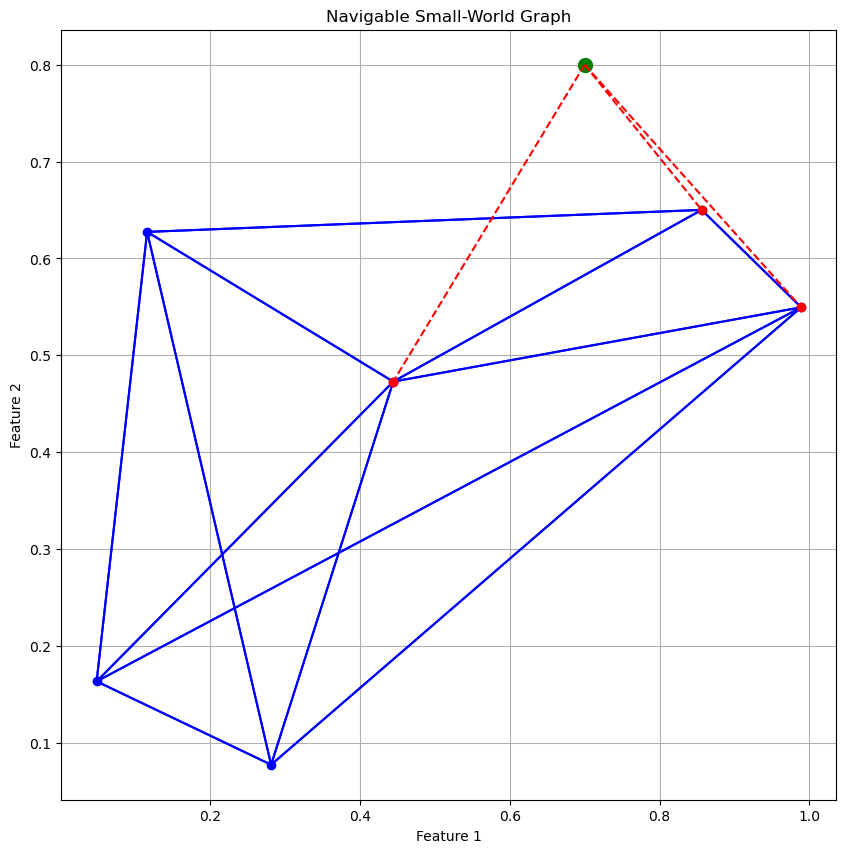

In [7]:
np.random.seed(45)
data_points = np.random.rand(6, 2)  # Using 10 data points for simplicity and clearer logging

nsw_graph = NSWGraph(m=3)

for idx, data in enumerate(data_points):
    nsw_graph.insert(Node(idx, data))

nsw_graph.ensure_connectivity()

query = Node(-1, np.array([0.7, 0.8]))

k_neighbors = nsw_graph.search(query, k=3)

print("K-Nearest Neighbors:")
for neighbor in k_neighbors:
    print(neighbor.idx)

visualize_nsw(nsw_graph.graph, query, k_neighbors)


INFO:root:Inserting node 0 with vector [1. 1.] into the graph...
INFO:root:Node 0 inserted.

INFO:root:Inserting node 1 with vector [1.2 1.1] into the graph...
INFO:root:Node 1 connected with node 0
INFO:root:Node 1 inserted.

INFO:root:Inserting node 2 with vector [0.9 1.3] into the graph...
INFO:root:Node 2 connected with node 0
INFO:root:Node 2 connected with node 1
INFO:root:Node 2 inserted.

INFO:root:Inserting node 3 with vector [1.1 0.9] into the graph...
INFO:root:Node 3 connected with node 0
INFO:root:Node 3 connected with node 1
INFO:root:Node 3 connected with node 2
INFO:root:Node 3 inserted.

INFO:root:Inserting node 4 with vector [1.  1.2] into the graph...
INFO:root:Node 4 connected with node 2
INFO:root:Node 4 connected with node 0
INFO:root:Node 4 connected with node 1
INFO:root:Node 4 inserted.

INFO:root:Inserting node 5 with vector [4. 4.] into the graph...
INFO:root:Node 5 connected with node 1
INFO:root:Node 5 connected with node 4
INFO:root:Node 5 connected with n

Removing node with idx: 5
Node with idx 5 removed.


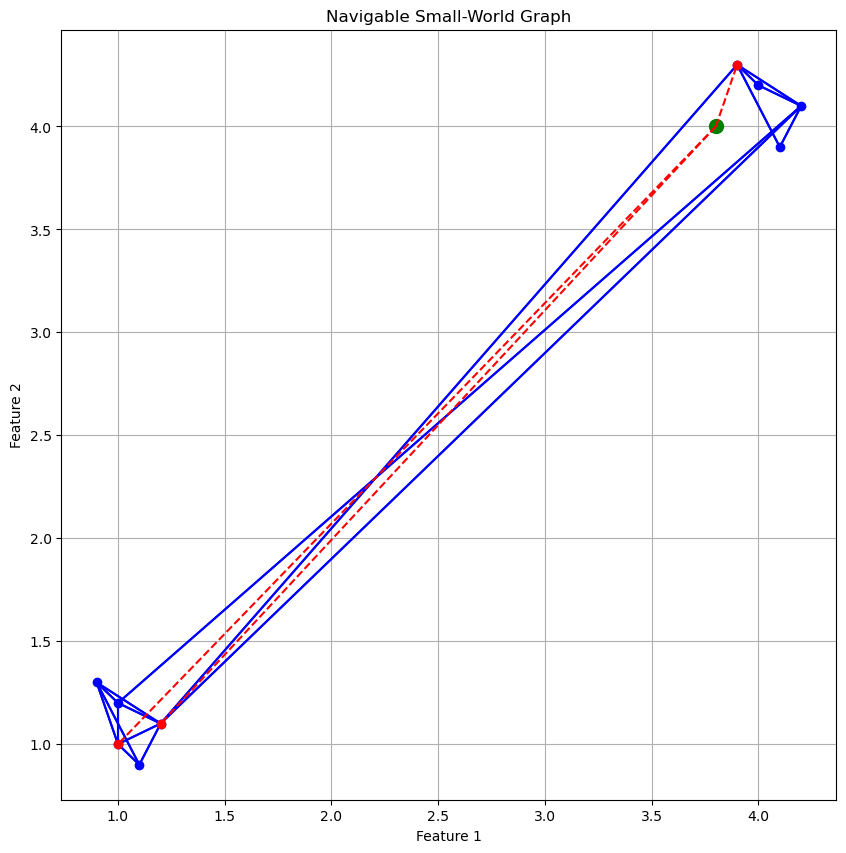

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 2D points in two separate clusters
data_points = np.array([
    [1, 1], [1.2, 1.1], [0.9, 1.3], [1.1, 0.9], [1, 1.2],  # Cluster 1
    [4, 4], [4.2, 4.1], [3.9, 4.3], [4.1, 3.9], [4, 4.2]   # Cluster 2
])

# Initialize NSW graph with m=1 which is quite small
nsw_graph = NSWGraph(m=3)

# Insert nodes into the graph
for idx, point in enumerate(data_points):
    nsw_graph.insert(Node(idx, point))

nsw_graph.remove_node(5)
# Ensure connectivity
nsw_graph.ensure_connectivity()

query = Node(-1, np.array([3.8, 4]))

k_neighbors = nsw_graph.search(query, k=3)

visualize_nsw(nsw_graph.graph, query, k_neighbors)